In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from NObSP_Decomposition_eps import ObSP, NObSP_SVM_single, NObSP_SVM_2order, NObSP_NN_single, NObSP_NN_2order, NObSP_NN_single_eps
from sklearn.model_selection import train_test_split
from Regression_NN import Regression_NN
from Regression_NN_NObSP import Regression_NN_NObSP

In [2]:
N = 1000; # Defining the number of datapoints
epochs = 2000 # Definning numebr of epochs to train the models
learning_rate = 0.05 # DEfining learning rate of the model

In [3]:
# Input variables
x0 = np.random.randn(N,)/3
x1 = np.random.randn(N,)/3
x2 = np.random.randn(N,)/3
x3 = np.random.randn(N,)
x4 = np.random.randn(N,)/3

In [4]:
# Nonlinear functions definition
g0 = np.abs(x0)
g1 = x1**3
g2 = np.exp(x2)
g3 = np.sin(2*x3)
g4 = np.zeros(N,) # Notice that the contribution of x4 on the output is zero.
g01 = 1*np.cos(2*(x0+x1)) # Second order interaction effect
noise = 0.01*np.random.randn(N,) # noise vector

In [5]:
# Generating the model output
y2 =  g0 + g1 + g2 + g3 + g4 + noise # Simulation done using only first order interactions in the output.
y =  g0 + g1 + g2 + g3 + g4 + g01 + noise # Simulation done using second order interactions in the output.

In [6]:
# Generating the input matriz for training
X = np.stack((x0, x1, x2, x3, x4), axis=1)
t = np.arange(0,N)

In [7]:
## Preparing the data for the model

train_split = int(0.8*N) # 80% of the data to be used as training

X = torch.from_numpy(X).type(torch.float) # Converting the input matrix to a Pytorch tensor format 
y = torch.from_numpy(y).type(torch.float).unsqueeze(dim=-1) # Converting the output data to a Pytorch tensor format 

# Normalizing the input data
X_mean = torch.mean(X,dim=0) 
X_var = torch.var(X,dim=0)
X = (X-X_mean)/X_var

# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size = train_split,
                                                    random_state=42) 

In [8]:
## Creating model for single nonlinear effects

model_1 = Regression_NN(5,1) # Creating the model
loss_fcn = nn.MSELoss() # Definning loss function
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=learning_rate)  # Defining optimizer

# Training loop for the model 1

for epoch in range(epochs):
    model_1.train() # Setting the model in training mode
    y_p, x_p = model_1(X_train) #forward pass
    #y_p.squeeze()
    loss = loss_fcn(y_p,
                    y_train)  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    model_1.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_pred, x_trans = model_1(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_pred,
                         y_test) # Evaluating loss
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained
    

model_1.eval() # Setting the model in evaluation mode
with torch.inference_mode():
    y_est_1, x_trans_total_1 = model_1(X) # Computing the nonlinear transformation of the input data X

Epoch: 0 | Loss: 4.45510 | test Loss: 1.36325
Epoch: 100 | Loss: 0.41937 | test Loss: 0.56095
Epoch: 200 | Loss: 0.34533 | test Loss: 0.50137
Epoch: 300 | Loss: 0.26947 | test Loss: 0.42650
Epoch: 400 | Loss: 0.15738 | test Loss: 0.28625
Epoch: 500 | Loss: 0.07008 | test Loss: 0.14998
Epoch: 600 | Loss: 0.03579 | test Loss: 0.09864
Epoch: 700 | Loss: 0.02322 | test Loss: 0.08241
Epoch: 800 | Loss: 0.01532 | test Loss: 0.07412
Epoch: 900 | Loss: 0.01207 | test Loss: 0.07055
Epoch: 1000 | Loss: 0.01034 | test Loss: 0.06860
Epoch: 1100 | Loss: 0.01031 | test Loss: 0.06786
Epoch: 1200 | Loss: 0.00755 | test Loss: 0.06568
Epoch: 1300 | Loss: 0.00652 | test Loss: 0.06462
Epoch: 1400 | Loss: 0.00741 | test Loss: 0.06457
Epoch: 1500 | Loss: 0.00652 | test Loss: 0.06372
Epoch: 1600 | Loss: 0.00289 | test Loss: 0.06226
Epoch: 1700 | Loss: 0.00190 | test Loss: 0.06219
Epoch: 1800 | Loss: 0.00328 | test Loss: 0.06143
Epoch: 1900 | Loss: 0.00360 | test Loss: 0.06113


In [9]:
P_xy_1, y_e_1, Alpha_NN_1 = NObSP_NN_single(X, y_est_1, model_1) # Computing the decomposition iusing NObSP. The Alpha parameters are the weigths for the Interpretation Layer
y_e_Alpha_1 = x_trans_total_1@Alpha_NN_1 # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_e_1 = y_e_1.cpu() # Setting th eoutput variables in the cpu.

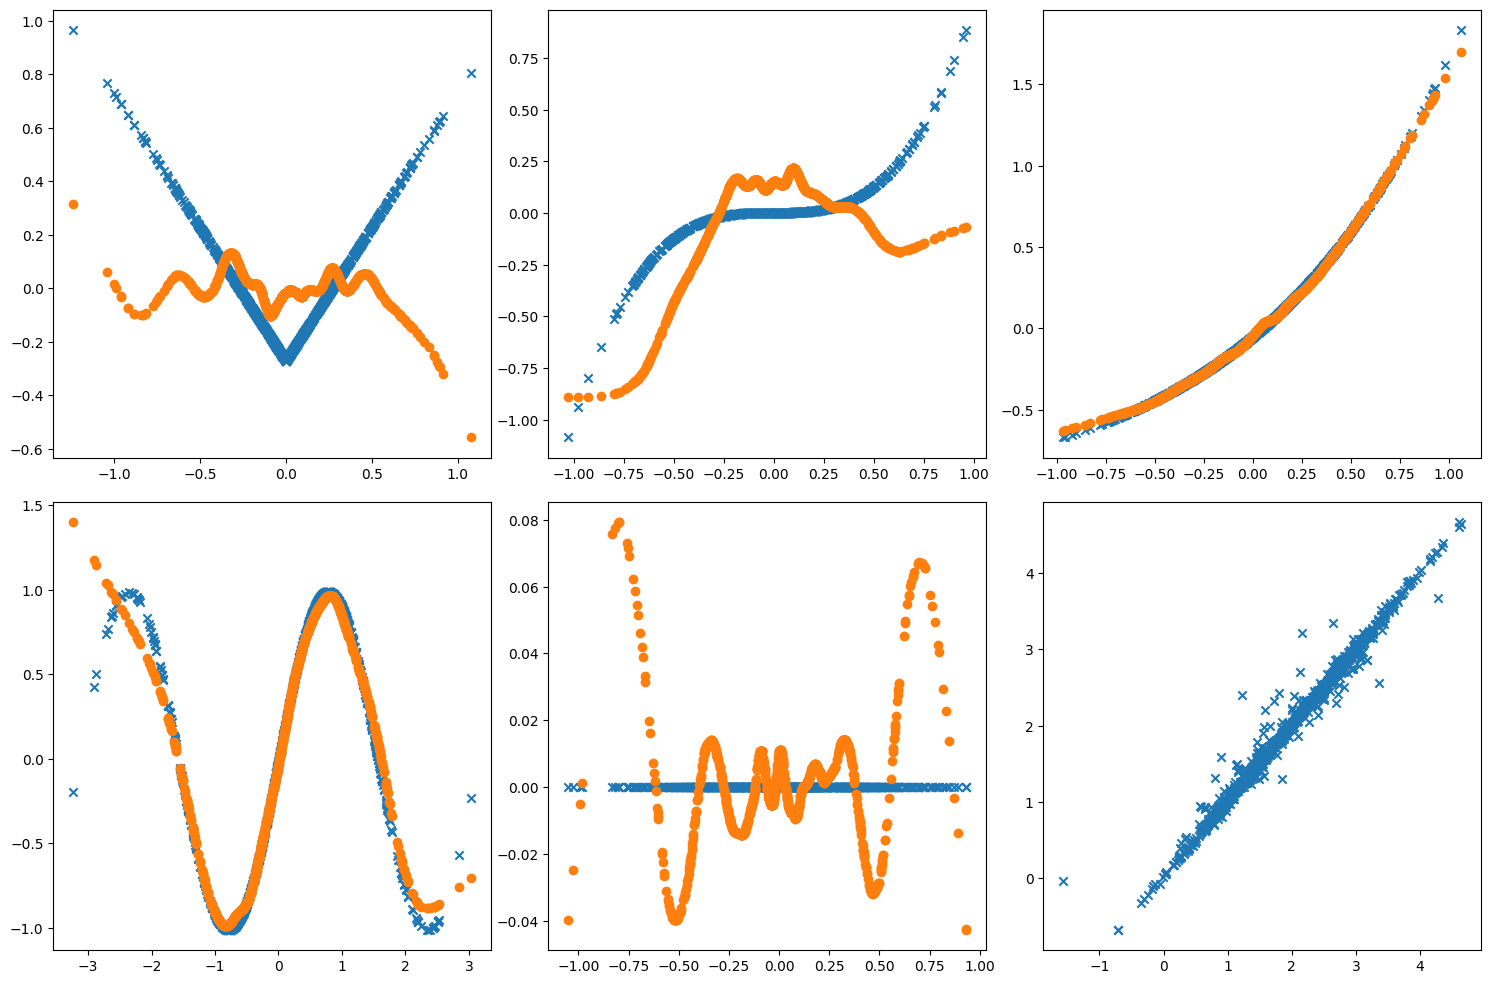

In [10]:
# Plotting the decomposition
fig, axs = plt.subplots(2,3, figsize = (15, 10))
plt.tight_layout()
axs[0,0].scatter(x0,g0-g0.mean(), marker='x') # Real nonlienar contribution of x0 on the output
axs[0,0].scatter(x0,y_e_1[:,0]-y_e_1[:,0].mean(),marker='o') # Estimated nonlinear contribution of x0 on the output

axs[0,1].scatter(x1,g1-g1.mean(), marker='x') # Real nonlienar contribution of x1 on the output
axs[0,1].scatter(x1,y_e_1[:,1]-y_e_1[:,1].mean(),marker='o') # Estimated nonlinear contribution of x1 on the output

axs[0,2].scatter(x2,g2-g2.mean(), marker='x') # Real nonlienar contribution of x2 on the output
axs[0,2].scatter(x2,y_e_1[:,2]-y_e_1[:,2].mean(),marker='o') # Estimated nonlinear contribution of x2 on the output

axs[1,0].scatter(x3,g3-g3.mean(), marker='x') # Real nonlienar contribution of x3 on the output
axs[1,0].scatter(x3,y_e_1[:,3]-y_e_1[:,3].mean(),marker='o') # Estimated nonlinear contribution of x3 on the output

axs[1,1].scatter(x4,g4-g4.mean(), marker='x') # Real nonlienar contribution of x4 on the output
axs[1,1].scatter(x4,y_e_1[:,4]-y_e_1[:,4].mean(),marker='o') # Estimated nonlinear contribution of x4 on the output

axs[1,2].scatter(y.cpu(),y_est_1.cpu(), marker='x') # Calinbration plot real output vs estiamted output
plt.show()

## New approach Using Epsilon

In [26]:
P_xy_1, _, y_est, y_est_eps, y_final, Alpha_NN_1 = NObSP_NN_single_eps(X, y_est_1, model_1, eps = 0.1) # Computing the decomposition iusing NObSP. The Alpha parameters are the weigths for the Interpretation Layer
y_e_Alpha_1 = x_trans_total_1@Alpha_NN_1 # Computing the decomposition using the Alpha coefficients, out-of-sample extension

y_est = y_est.cpu() # Setting the output variables in the cpu.
y_est_eps = y_est_eps.cpu()
y_final = y_final.cpu()

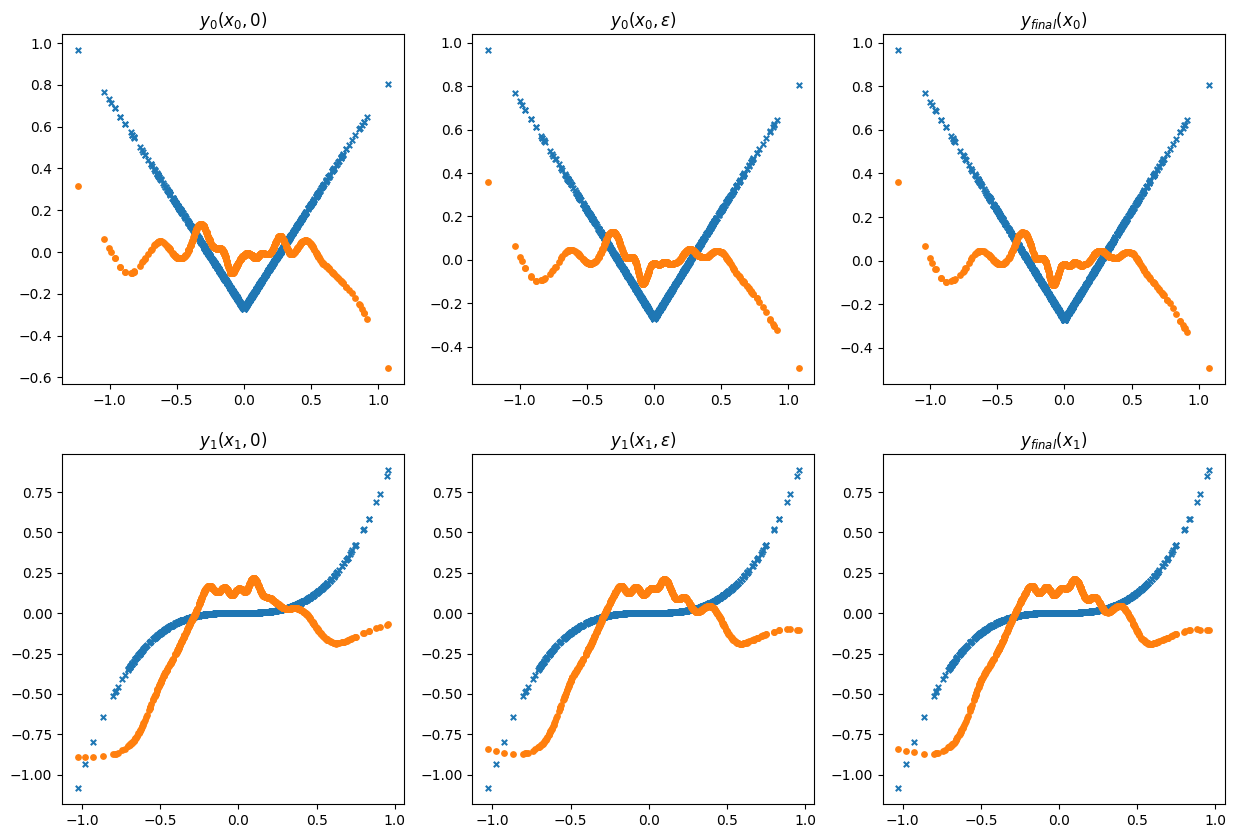

In [27]:
fig, axs = plt.subplots(2,3, figsize = (15, 10))
s = 15
axs[0,0].scatter(x0,g0-g0.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[0,0].scatter(x0,y_est[:,0]-y_est[:,0].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[0,0].set_title("$y_{0}(x_{0}, 0)$")

axs[1,0].scatter(x1,g1-g1.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[1,0].scatter(x1,y_est[:,1]-y_est[:,1].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[1,0].set_title("$y_{1}(x_{1}, 0)$")


axs[0,1].scatter(x0,g0-g0.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[0,1].scatter(x0,y_est_eps[:,0]-y_est_eps[:,0].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[0,1].set_title("$y_{0}(x_{0}, \epsilon)$")

axs[1,1].scatter(x1,g1-g1.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[1,1].scatter(x1,y_est_eps[:,1]-y_est_eps[:,1].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[1,1].set_title("$y_{1}(x_{1}, \epsilon)$")


axs[0,2].scatter(x0,g0-g0.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[0,2].scatter(x0,y_final[:,0]-y_final[:,0].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[0,2].set_title("$y_{final}(x_{0})$")

axs[1,2].scatter(x1,g1-g1.mean(), marker='x', s = s) # Real nonlienar contribution of x0 on the output
axs[1,2].scatter(x1,y_final[:,1]-y_final[:,1].mean(),marker='o', s = s) # Estimated nonlinear contribution of x0 on the output
axs[1,2].set_title("$y_{final}(x_{1})$")

plt.show()